In [1]:
import os
import shutil
import random

source_dir = 'data'

data_dir = 'flowers'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Ratios that speak truth
train_ratio = 0.7
valid_ratio = 0.1
test_ratio = 0.2

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

class_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

print(f'Tổng số loài hoa: {len(class_folders)}')

for c in class_folders:
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)

for c in class_folders:
    class_path = os.path.join(source_dir, c)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)

    n = len(images)
    train_end = int(n * train_ratio)
    valid_end = train_end + int(n * valid_ratio)

    train_images = images[:train_end]
    valid_images = images[train_end:valid_end]
    test_images = images[valid_end:]

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, c, img))

    for img in valid_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_dir, c, img))

    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, c, img))

    print(f'{c}: train {len(train_images)}, valid {len(valid_images)}, test {len(test_images)}')

print("Chia tập dữ liệu xong, ready to rock that model training!")

Tổng số loài hoa: 102
1: train 28, valid 4, test 8
10: train 31, valid 4, test 10
100: train 34, valid 4, test 11
101: train 40, valid 5, test 13
102: train 33, valid 4, test 11
11: train 60, valid 8, test 19
12: train 60, valid 8, test 19
13: train 34, valid 4, test 11
14: train 33, valid 4, test 11
15: train 34, valid 4, test 11
16: train 28, valid 4, test 9
17: train 59, valid 8, test 18
18: train 57, valid 8, test 17
19: train 34, valid 4, test 11
2: train 42, valid 6, test 12
20: train 39, valid 5, test 12
21: train 28, valid 4, test 8
22: train 41, valid 5, test 13
23: train 63, valid 9, test 19
24: train 29, valid 4, test 9
25: train 28, valid 4, test 9
26: train 28, valid 4, test 9
27: train 28, valid 4, test 8
28: train 46, valid 6, test 14
29: train 54, valid 7, test 17
3: train 28, valid 4, test 8
30: train 59, valid 8, test 18
31: train 36, valid 5, test 11
32: train 31, valid 4, test 10
33: train 32, valid 4, test 10
34: train 28, valid 4, test 8
35: train 30, valid 4, tes

In [1]:
data_dir = 'flowers'
train_dir = data_dir + '/train' 
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [2]:
# Jupyter notebook settings
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
import pandas as pd
import time
import json

from collections import OrderedDict
from PIL import Image
import seaborn as sns

from torchvision import datasets, models, transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_data_transforms = transforms.Compose ([transforms.RandomRotation (30),
                                             transforms.RandomResizedCrop (224),
                                             transforms.RandomHorizontalFlip (),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

valid_data_transforms = transforms.Compose ([transforms.Resize (255),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

test_data_transforms = transforms.Compose ([transforms.Resize (255),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

# TODO: Load the datasets with ImageFolder
train_image_datasets = datasets.ImageFolder (train_dir, transform = train_data_transforms)
valid_image_datasets = datasets.ImageFolder (valid_dir, transform = valid_data_transforms)
test_image_datasets = datasets.ImageFolder (test_dir, transform = test_data_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_image_datasets, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size = 64, shuffle = True)

In [4]:
def load_model(hidden_units):
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    if hidden_units:
        classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 4096)),
            ('relu1', nn.ReLU()),
            ('dropout1', nn.Dropout(p=0.1)),
            ('fc2', nn.Linear(4096, hidden_units)),
            ('relu2', nn.ReLU()),
            ('dropout2', nn.Dropout(p=0.1)),
            ('fc3', nn.Linear(hidden_units, 102)),
            ('output', nn.LogSoftmax(dim=1))
        ]))
    else:  # if hidden_units not given
        classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 4096)),
            ('relu1', nn.ReLU()),
            ('dropout1', nn.Dropout(p=0.1)),
            ('fc2', nn.Linear(4096, 2048)),
            ('relu2', nn.ReLU()),
            ('dropout2', nn.Dropout(p=0.1)),
            ('fc3', nn.Linear(2048, 102)),
            ('output', nn.LogSoftmax(dim=1))
        ]))

    # Replace the classifier in vgg16 model
    model.classifier = classifier
    return model


In [5]:
# chạy thư viện cần thiết và chỉnh các tham số ở đây

epochs = 10  # Bạn có thể thay đổi số epoch
learning_rate = 0.001
hidden_units = 2048
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# khởi chạy model
model = load_model(hidden_units)
model.to(device)

# Định nghĩa các hàm Loss và Optimizer
criterion = nn.NLLLoss()  # Hàm mất mát cho phân loại nhiều lớp
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate) # Sử dụng Adam optimizer

c:\Users\nam\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nam\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Gán ánh xạ class_to_idx từ dataset vào model để dùng khi dự đoán
model.class_to_idx = train_image_datasets.class_to_idx

In [8]:
#Hàm để Train model
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs):
    train_losses = []
    train_accuracies = []
    valid_accuracies = []
    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()  # Đặt mô hình vào chế độ huấn luyện
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Đặt gradient về 0 trước khi tính toán gradient mới

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass và cập nhật tham số mô hình
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Tính độ chính xác
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Tính toán loss và accuracy trên training set
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation loop
        model.eval()  # Đặt mô hình vào chế độ evaluation
        correct = 0
        total = 0
        with torch.no_grad():  # Không tính gradient khi đánh giá trên validation set
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Accuracy: {valid_accuracy:.2f}%")

         # Lưu giá trị vào các danh sách để vẽ đồ thị
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # Lưu mô hình nếu độ chính xác validation cao hơn
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            
            torch.save(model.state_dict(), 'best_model.pth')  # Lưu mô hình tốt nhất

    # Vẽ đồ thị
    # Biểu đồ loss
    plt.figure(figsize=(6, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
    plt.title('Train Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Biểu đồ accuracy
    plt.figure(figsize=(6, 5))
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='green')
    plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy', color='red')
    plt.title('Train and Validation Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    plt.show()

    print("Training complete.")

Epoch 1/10 - Train Loss: 3.0055, Train Accuracy: 33.46%
Validation Accuracy: 63.87%
Epoch 2/10 - Train Loss: 1.3286, Train Accuracy: 63.62%
Validation Accuracy: 77.16%
Epoch 3/10 - Train Loss: 1.0181, Train Accuracy: 72.78%
Validation Accuracy: 81.55%
Epoch 4/10 - Train Loss: 0.9053, Train Accuracy: 75.19%
Validation Accuracy: 83.48%
Epoch 5/10 - Train Loss: 0.8166, Train Accuracy: 77.26%
Validation Accuracy: 85.16%
Epoch 6/10 - Train Loss: 0.7309, Train Accuracy: 79.53%
Validation Accuracy: 86.84%
Epoch 7/10 - Train Loss: 0.7285, Train Accuracy: 80.09%
Validation Accuracy: 87.87%
Epoch 8/10 - Train Loss: 0.6687, Train Accuracy: 81.27%
Validation Accuracy: 86.32%
Epoch 9/10 - Train Loss: 0.6665, Train Accuracy: 81.34%
Validation Accuracy: 86.06%
Epoch 10/10 - Train Loss: 0.6263, Train Accuracy: 82.29%
Validation Accuracy: 87.61%


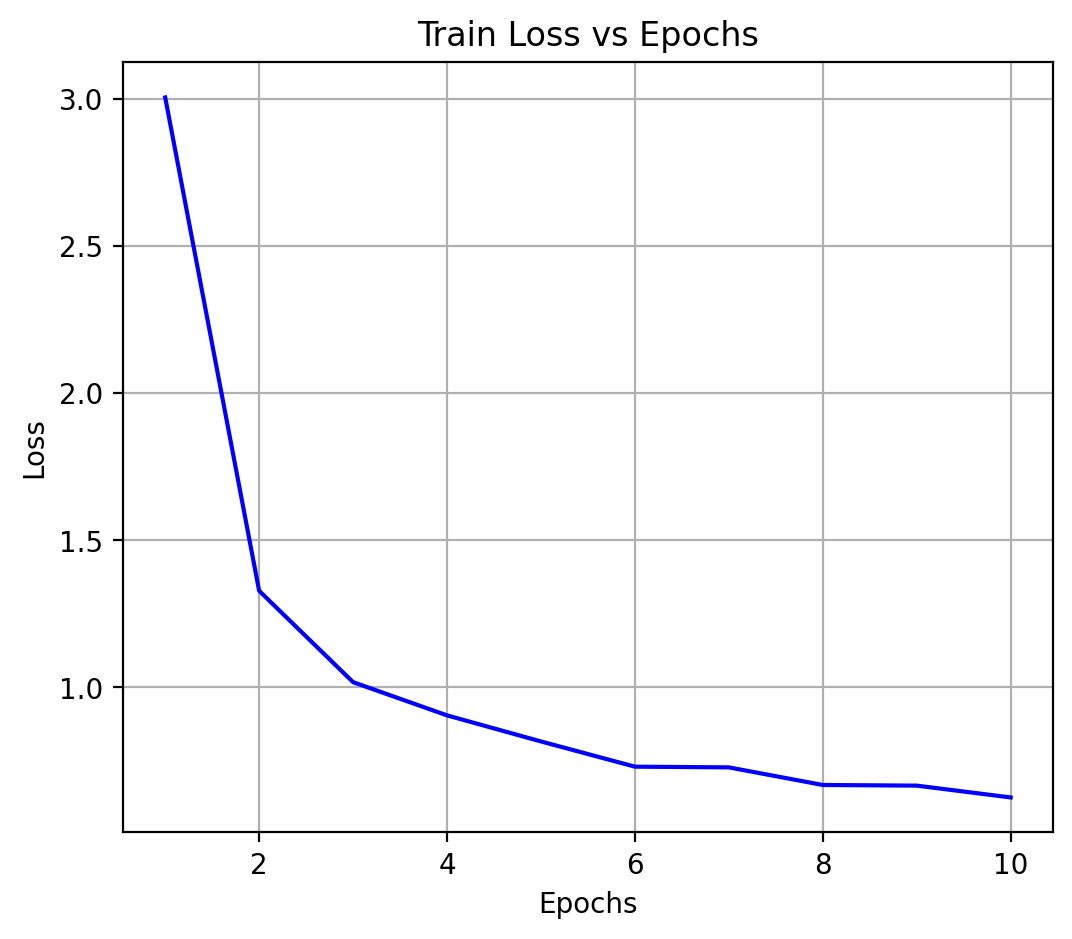

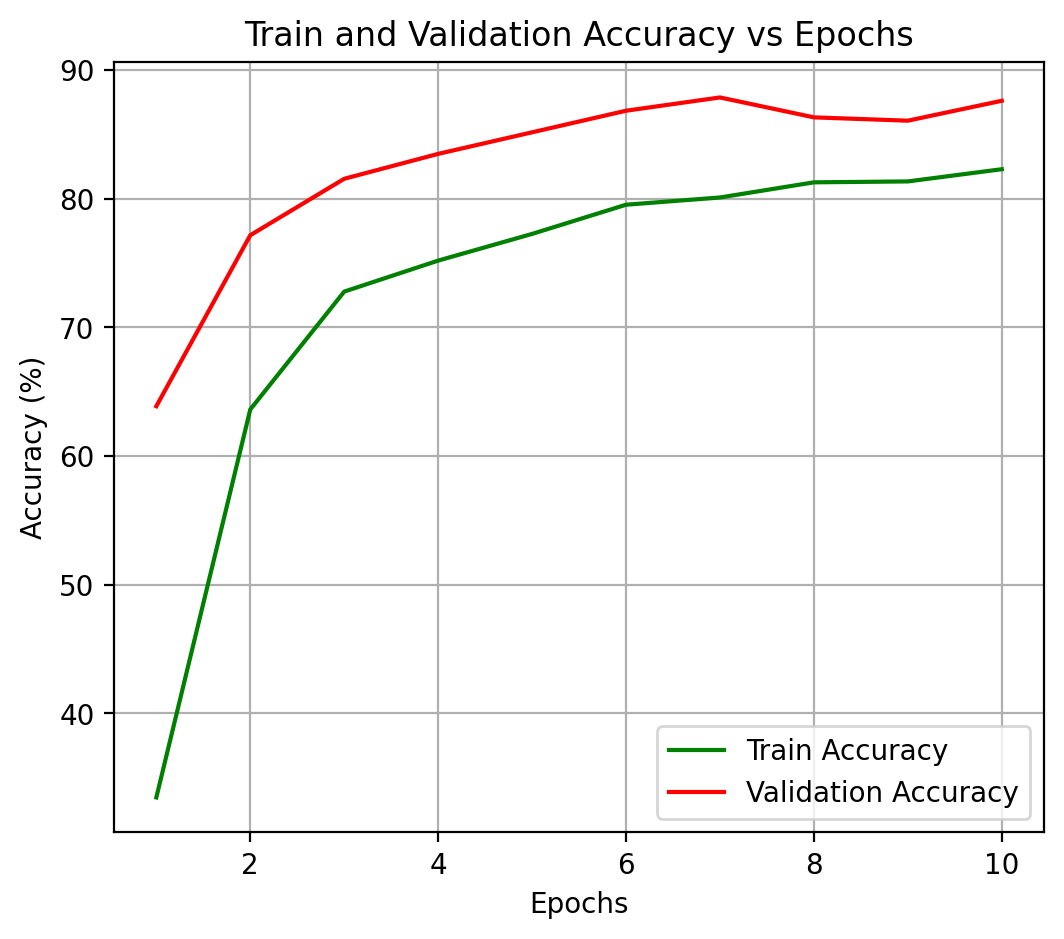

Training complete.


In [9]:
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs)

Test model bằng phương pháp Hold-out

In [10]:
def test_model(model, test_loader):
    model.eval()  # Đặt mô hình vào chế độ evaluation
    correct = 0
    total = 0
    with torch.no_grad():  # Không tính gradient khi đánh giá trên test set
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

In [11]:
test_model(model,test_loader)

Test Accuracy: 88.65%


In [12]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img, title=None):
    # img: tensor image, chuẩn hóa về dạng [0,1] nếu cần
    img = img.cpu().numpy().transpose((1, 2, 0))  # chuyển từ [C,H,W] sang [H,W,C]
    # Nếu ảnh được chuẩn hóa, bạn cần hồi lại chuẩn hóa ở đây (ví dụ: mean/std)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Tính đúng/sai
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Lấy các ảnh dự đoán sai
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    incorrect_images.append(inputs[i].cpu())
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_preds.append(predicted[i].cpu().item())

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # In ra một số ảnh dự đoán sai (ví dụ 5 ảnh)
    n_show = min(5, len(incorrect_images))
    for i in range(n_show):
        title = f"True: {incorrect_labels[i]}, Pred: {incorrect_preds[i]}"
        imshow(incorrect_images[i], title=title)


In [13]:
torch.save(model.state_dict(), 'best_model_final.pth')

In [14]:
# Tải mô hình đã lưu
# model.load_state_dict(torch.load('best_model2.pth'))

In [15]:
# test_model(model, test_loader)

In [16]:
with open('cat_to_name.json', 'r') as f:
  cat_to_name = json.load(f)
len (cat_to_name)
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 